In [2]:
import pandas as pd

In [3]:
# Retweet networks
dtype = {'source': str,
         'target': str,
         'weight': int}

observation_net_df = pd.read_csv('data/observation_retweet_network.csv', dtype=dtype)
evaluation_net_df = pd.read_csv('data/evaluation_retweet_network.csv', dtype=dtype)

In [4]:
# Rankings
dtype = {'author_id': str}
popularity_rank_df = pd.read_csv('data/popularity_rank.csv', index_col='author_id', dtype=dtype)
influence_rank_df = pd.read_csv('data/influence_rank.csv', index_col='author_id', dtype=dtype)
fib_rank_df = pd.read_csv('data/fib_rank.csv', index_col='author_id', dtype=dtype)
tefib_rank_df = pd.read_csv('data/tefib_rank.csv', index_col='author_id', dtype=dtype)
retweets_rank_df = pd.read_csv('data/retweets_rank.csv', index_col='author_id', dtype=dtype)
fraction_rank_df = pd.read_csv('data/fraction_rank.csv', index_col='author_id', dtype=dtype)
compound_rank_df = pd.read_csv('data/linear_rank.csv', index_col='author_id', dtype=dtype)

In [5]:
# Dismantling procedure by given ranking
def network_dismantle(network_df, ranking_df):
    
    print("Dismantling...")
    
    full_misinformation = network_df.weight.sum()

    dismantled_network_df = network_df.copy()

    network_sources = set(network_df.source.unique())
    
    track = [(None, 1.0)]
    
    for author, _ in ranking_df.itertuples(): # reverse rank -> ranking_df.iloc[::-1].itertuples()

        if author in network_sources:

            # The network without the current author as source
            dismantled_network_df = dismantled_network_df[dismantled_network_df.source != author]
    
            # The ratio of current remaining misinformation in the network
            remaining_misinformation = dismantled_network_df.weight.sum() / full_misinformation
            
            track.append((author, remaining_misinformation))

    # Adjust sequence to have same lenght
    n_residual_sources = dismantled_network_df.source.nunique()
    track += [track[-1] for _ in range(n_residual_sources)]
    
    return track

# Test
# network_dismantle(observation_net_df, popularity_rank_df)

### Optimal rank

In [6]:
optimal_rank_df = evaluation_net_df[['source', 'weight']].groupby('source').sum()
optimal_rank_df = optimal_rank_df.sort_values(by='weight', ascending=False)
optimal_rank_df.rename(columns={'weight': 'Optimal'}, inplace=True)
optimal_rank_df.index.rename('author_id', inplace=True)

# TODO: remove unknown users. Users never seen during observation cannot be removed by this method.
# NOTE: A user that never posted anything in observation can have some repost activity so should be a known user.
observed_user = observation_net_df[['source']].drop_duplicates().reset_index(drop=True).rename(columns={'source': 'author_id'})
#optimal_rank_df = optimal_rank_df.merge(observed_user, how='right', on='author_id').fillna(0).astype(int)
#optimal_rank_df.sort_values(by='Optimal', ascending=False, inplace=True)
#optimal_rank_df.set_index('author_id', inplace=True)
#optimal_rank_df.index = optimal_rank_df.index.astype(str)

In [7]:
optimal_rank_df

,Optimal
author_id,
1683455144,25704
4758512368,13638
1248216384577953792,10135
245969509,6918
1032615842,3633
...,...
429423249,1
1398737457185763378,1
429974408,1


### Analysis

In [8]:
# evaluation period
popularity_dismantle = network_dismantle(evaluation_net_df, popularity_rank_df)
influence_dismantle = network_dismantle(evaluation_net_df, influence_rank_df)
fib_dismantle = network_dismantle(evaluation_net_df, fib_rank_df)
tefib_dismantle = network_dismantle(evaluation_net_df, tefib_rank_df)
retweets_dismantle = network_dismantle(evaluation_net_df, retweets_rank_df)
fraction_dismantle = network_dismantle(evaluation_net_df, fraction_rank_df)
compound_dismantle = network_dismantle(evaluation_net_df, compound_rank_df)
# Ground truth
optimal_dismantle = network_dismantle(evaluation_net_df, optimal_rank_df)

Dismantling...
Dismantling...
Dismantling...
Dismantling...
Dismantling...
Dismantling...
Dismantling...
Dismantling...


In [9]:
# observation period
#popularity_dismantle = network_dismantle(observation_net_df, popularity_rank_df)
#influence_dismantle = network_dismantle(observation_net_df, influence_rank_df)
#fib_dismantle = network_dismantle(observation_net_df, fib_rank_df)
#retweets_dismantle = network_dismantle(observation_net_df, retweets_rank_df)
#fraction_dismantle = network_dismantle(observation_net_df, fraction_rank_df)
#optimal_dismantle = network_dismantle(observation_net_df, optimal_rank_df)

In [10]:
# Paper results
dismantle_df = pd.DataFrame({'Popularity': [y for _, y in popularity_dismantle],
                             'Influence': [y for _, y in influence_dismantle],
                             'FIB-index': [y for _, y in fib_dismantle],
                             'Optimal': [y for _, y in optimal_dismantle]
                            })

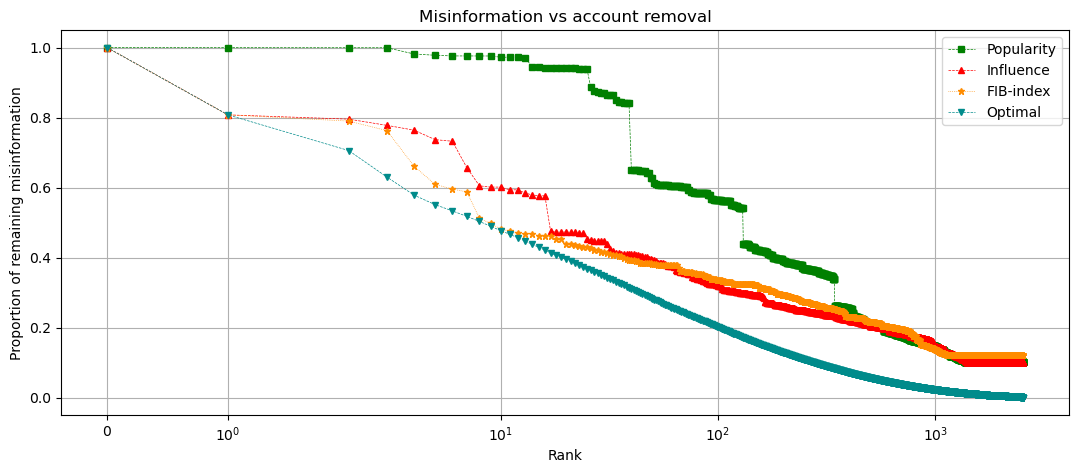

In [11]:
colors = ['green', 'red', 'darkorange', 'darkcyan']
styles = ['s--', '^--', '*:' ,'v--']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(13, 5),
                            grid=True,
                            color=colors,
                            style=styles,
                            linewidth=0.5,
                            ms=5,
                            title='Misinformation vs account removal');

ax.set_ylabel("Proportion of remaining misinformation");

ax.set_xlabel("Rank");

In [12]:
print(len(compound_dismantle))
print(len(fib_dismantle))
print(len(retweets_dismantle))

2540
2540
2540


In [13]:
dismantle_df = pd.DataFrame({'Popularity': [y for _, y in popularity_dismantle],
                             'Influence': [y for _, y in influence_dismantle],
                             'FIB-index': [y for _, y in fib_dismantle],
                             'Retweets': [y for _, y in retweets_dismantle],
                             'Fraction': [y for _, y in fraction_dismantle], # Same of influence
                             'Compound': [y for _, y in compound_dismantle],
                             'Optimal': [y for _, y in optimal_dismantle]
                            })

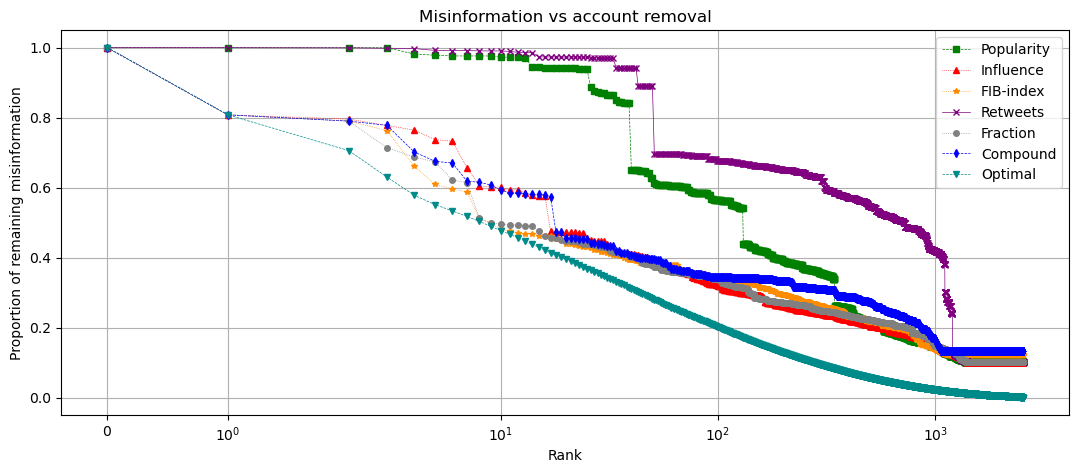

In [14]:
colors = ['green', 'red', 'darkorange', 'purple', 'grey', 'blue', 'darkcyan']
styles = ['s--', '^:', '*:', 'x-', 'o:', 'd--','v--']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(13, 5),
                            grid=True,
                            color=colors,
                            style=styles,
                            linewidth=0.5,
                            ms=4,
                            title='Misinformation vs account removal');

ax.set_ylabel("Proportion of remaining misinformation");

ax.set_xlabel("Rank");

In [15]:
# TODO: Indagare su account "repeater" non postano disinformazione ma la ritrasmettono

In [16]:
dismantle_df

,Popularity,Influence,FIB-index,Retweets,Fraction,Compound,Optimal
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999806,0.807888,0.807888,0.999865,0.807888,0.807888,0.807888
2,0.999664,0.795668,0.790107,0.999402,0.790107,0.790107,0.705958
3,0.999634,0.777887,0.762954,0.998333,0.714358,0.777887,0.630208
4,0.981853,0.764195,0.661024,0.997399,0.687205,0.702138,0.578503
...,...,...,...,...,...,...,...
2535,0.101975,0.101975,0.122155,0.101975,0.101975,0.133732,0.000030
2536,0.101975,0.101975,0.122155,0.101975,0.101975,0.133732,0.000022
2537,0.101975,0.101975,0.122155,0.101975,0.101975,0.133732,0.000015
2538,0.101975,0.101975,0.122155,0.101975,0.101975,0.133732,0.000007


## TeFIB comparisons

In [38]:
# Paper results
dismantle_df = pd.DataFrame({'Influence': [y for _, y in influence_dismantle],
                             'TeFIB-index\n(alpha=0.15)\n(interval = 5d)': [y for _, y in tefib_dismantle],
                             'FIB-index': [y for _, y in fib_dismantle],
                             'Optimal': [y for _, y in optimal_dismantle]
                            })

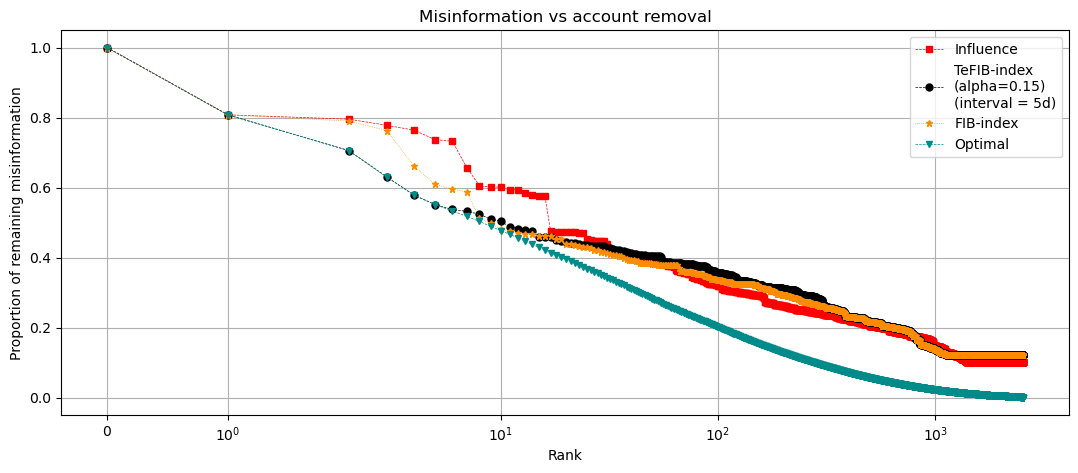

In [39]:
colors = ['red', 'black', 'darkorange', 'darkcyan']
styles = ['s--', 'o--', '*:' ,'v--']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(13, 5),
                            grid=True,
                            color=colors,
                            style=styles,
                            linewidth=0.5,
                            ms=5,
                            title='Misinformation vs account removal');

ax.set_ylabel("Proportion of remaining misinformation");

ax.set_xlabel("Rank");